# Karras pre-conditioning

In [ ]:
# !pip install k-diffusion seaborn

In [2]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [6]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [7]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

Generating test split: 100%|██████████| 10000/10000 [00:01<00:00, 5675.82 examples/s]


In [8]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb,yb = b = next(iter(dl))

In [9]:
# sig_data = xb.std()
sig_data = 0.66

`y` is clean signal, `n` is `N(0,1)` noise.

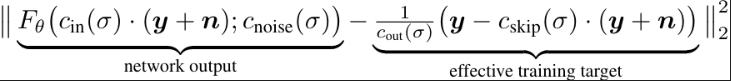

In [10]:
def scalings(sig):
    totvar = sig**2 + sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2 / totvar, sig * sig_data / totvar.sqrt(), 1 / totvar.sqrt()

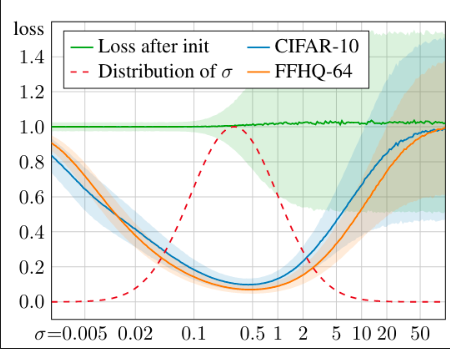

In [11]:
sig_samp = (torch.randn([10000]) * 1.2 - 1.2).exp()

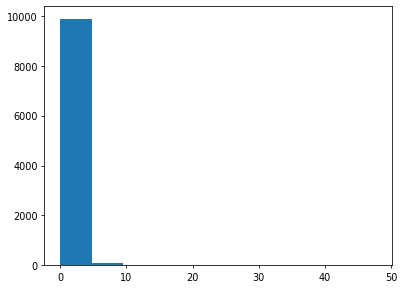

In [12]:
plt.hist(sig_samp);

In [13]:
import seaborn as sns

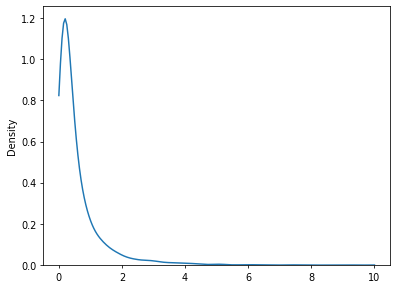

In [14]:
sns.kdeplot(sig_samp, clip=(0, 10));

In [15]:
def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

In [16]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=fc.defaults.cpus)

In [17]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [18]:
dl = dls.train
(noised_input,sig),target = b = next(iter(dl))

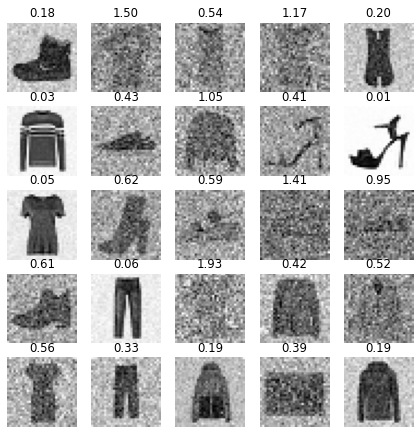

In [19]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

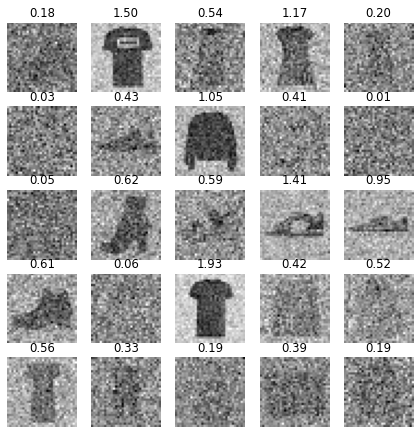

In [20]:
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [21]:
noised_input.mean(),noised_input.std(),target.mean(),target.std()

(tensor(-0.69019), tensor(1.01665), tensor(-0.40007), tensor(1.03293))

## Train

In [22]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [23]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [24]:
lr = 1e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
1.021,0,train
0.842,0,eval
0.621,1,train
0.416,1,eval
0.322,2,train
0.258,2,eval
0.226,3,train
0.212,3,eval
0.201,4,train
0.233,4,eval


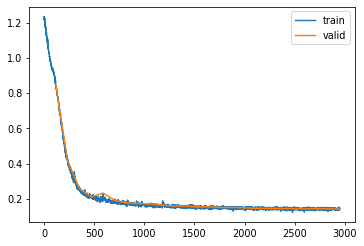

In [26]:
learn.fit(epochs)

In [27]:
torch.save(learn.model, '../models/fashion_karras.pkl')
# model = learn.model = torch.load('../models/fashion_karras.pkl').cuda()

loss,epoch,train
0.143,0,train
0.144,0,eval
0.144,1,train
0.145,1,eval
0.146,2,train
0.148,2,eval
0.148,3,train
0.151,3,eval
0.149,4,train
0.156,4,eval


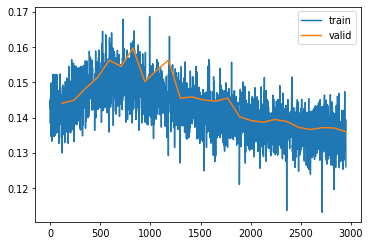

In [28]:
lr=1e-4
# learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
learn.lr = lr
learn.fit(epochs)

In [26]:
# torch.save(learn.model, '../models/fashion_karras.pkl')
model = learn.model = torch.load('../models/fashion_karras.pkl', map_location=def_device)

In [27]:
def denoise(target, noised_input): return target * c_out  + noised_input * c_skip

In [28]:
with torch.no_grad():
    sigr = sig.to(def_device).reshape(-1, 1, 1, 1)
    c_skip, c_out, c_in = scalings(sigr)
    targ_pred = learn.model((noised_input.to(def_device), sig.to(def_device)))
    x0_pred = denoise(targ_pred, noised_input.to(def_device) / c_in)

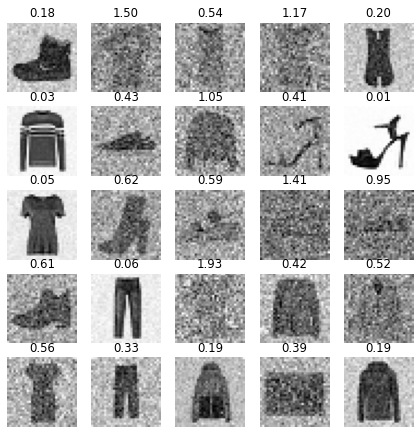

In [29]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

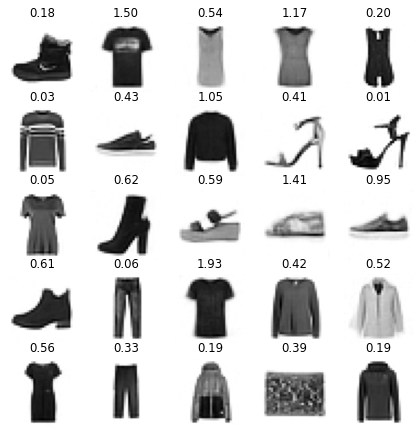

In [30]:
show_images(x0_pred[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

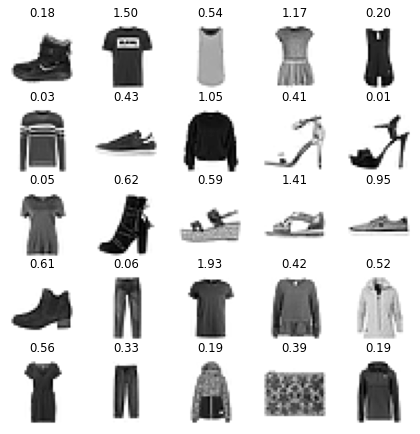

In [31]:
show_images(denoise(target.to(def_device), noised_input.to(def_device)/c_in)[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

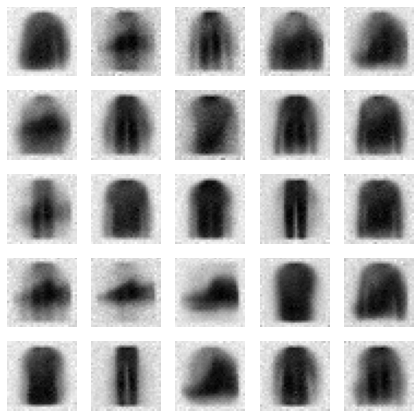

In [32]:
# one shot generation from noise
sig_r = tensor(80.).to(def_device).reshape(-1, 1, 1, 1)
c_skip, c_out, c_in = scalings(sig_r)
x_r = torch.randn(32, 1, 32, 32).to(def_device) * sig_r
with torch.no_grad():
    targ_pred = learn.model((x_r * c_in, sig_r.squeeze()))
    # x0_pred = denoise(targ_pred, x_r / c_in)
    x0_pred = denoise(targ_pred, x_r)
show_images(x0_pred[:25], imsize=1.5)

## Sampling

In [34]:
from miniai.fid import ImageEval

In [35]:
cmodel = torch.load('../models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [36]:
sz = (512,1,32,32)

In [37]:
sz = (2048,1,32,32)

In [38]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7., device='cpu'):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1 / rho)
    max_inv_rho = sigma_max**(1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).to(device)

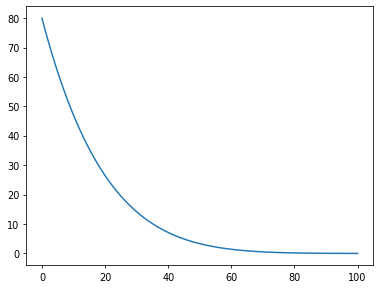

In [39]:
sk = sigmas_karras(100)
plt.plot(sk);

In [48]:
def denoise(model, x, sig):
    c_skip, c_out, c_in = scalings(sig)
    return model((x * c_in, sig)) * c_out + x * c_skip

In [49]:
def get_ancestral_step(sigma_from, sigma_to, eta=1.):
    if not eta: return sigma_to, 0.
    var_to, var_from = sigma_to**2, sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from - var_to) / var_from)**0.5)
    return (var_to - sigma_up**2)**0.5, sigma_up

In [76]:
@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down,sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

In [51]:
@torch.no_grad()
def sample_euler(x, sigs, i, model, eta=1.):
    sig, sig2 = sigs[i], sigs[i + 1]
    denoised = denoise(model, x, sig)
    return x + (x - denoised) / sig * (sig2 - sig)

In [52]:
@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn/(n-1), 2**0.5-1) if s_tmin<=sig<=s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2-sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x-denoised)/sig
    dt = sig2-sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2-denoised_2)/sig2
    d_prime = (d+d_2)/2
    return x + d_prime*dt

In [53]:
def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).to(model.device) * sigma_max
    sigs = sigmas_karras(steps, sigma_max=sigma_max, device=model.device)
    for i in progress_bar(range(len(sigs) - 1)):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

In [81]:
set_seed(42)
# preds = sample_lms(model, steps=20, order=3)
# preds = sample(sample_euler_ancestral, model, steps=100, eta=0.5)
preds = sample(sample_euler, model, steps=100)
# preds = sample(sample_euler, model, steps=100, eta=0.5)
# preds = sample(sample_heun, model, steps=20, s_churn=0.5)

In [82]:
s = preds[-1]
s.min(), s.max()

(tensor(-1.16313, device='cuda:0'), tensor(1.46050, device='cuda:0'))

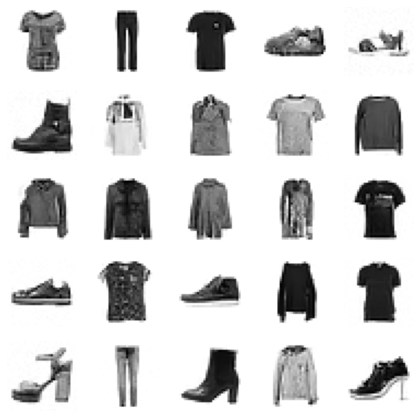

In [83]:
show_images(s[:25].clamp(-1, 1), imsize=1.5)

In [84]:
# euler 100
ie.fid(s),ie.kid(s),s.shape

(6.423828125, 0.009999996051192284, torch.Size([2048, 1, 32, 32]))

In [85]:
def sample_evaluate(sampler, model, steps=100, **kwargs):
    set_seed(42)
    preds = sample(sampler, model, steps=steps, **kwargs)
    s = preds[-1]
    print(s.min(), s.max())
    show_images(s[:25].clamp(-1, 1), imsize=1.5)
    print(ie.fid(s),ie.kid(s),s.shape)

tensor(-1.16313, device='cuda:0') tensor(1.46050, device='cuda:0')
6.427734375 0.009999996051192284 torch.Size([2048, 1, 32, 32])


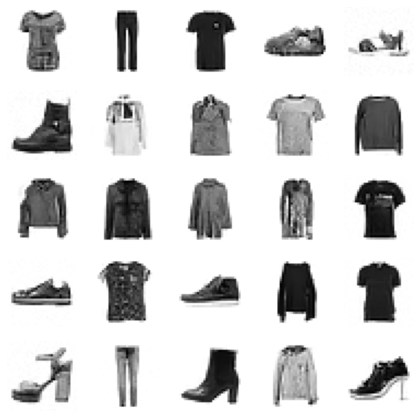

In [86]:
# euler 100, 0.5
sample_evaluate(sample_euler, model, steps=100, eta=0.5)

tensor(-1.12711, device='cuda:0') tensor(1.38386, device='cuda:0')
8.6199951171875 0.05746440216898918 torch.Size([2048, 1, 32, 32])


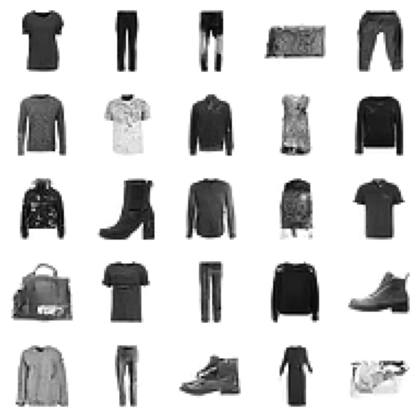

In [87]:
# ancestral 100 0.5
sample_evaluate(sample_euler_ancestral, model, steps=100, eta=0.5)

tensor(-1.17123, device='cuda:0') tensor(1.48565, device='cuda:0')
5.96630859375 3.914716944564134e-05 torch.Size([2048, 1, 32, 32])


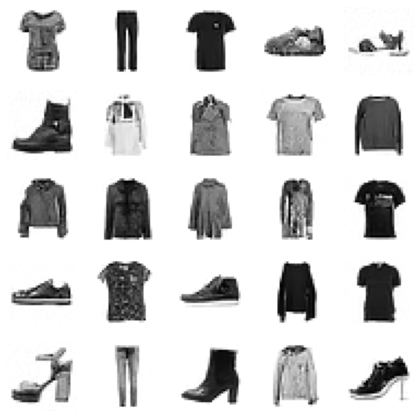

In [92]:
# heun 50
sample_evaluate(sample_heun, model, steps=50, s_churn=0.)

tensor(-1.18339, device='cuda:0') tensor(1.51745, device='cuda:0')
6.1348876953125 0.00369138247333467 torch.Size([2048, 1, 32, 32])


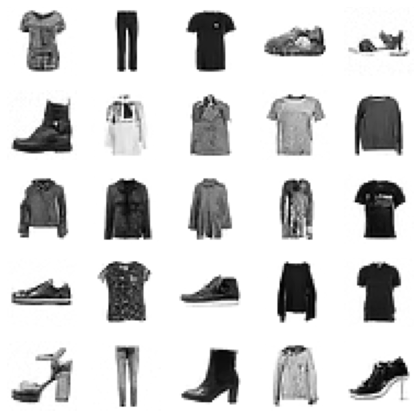

In [93]:
# heun 20
sample_evaluate(sample_heun, model, steps=20, s_churn=0.)

tensor(-1.08594, device='cuda:0') tensor(1.41317, device='cuda:0')
6.5567626953125 0.038649313151836395 torch.Size([2048, 1, 32, 32])


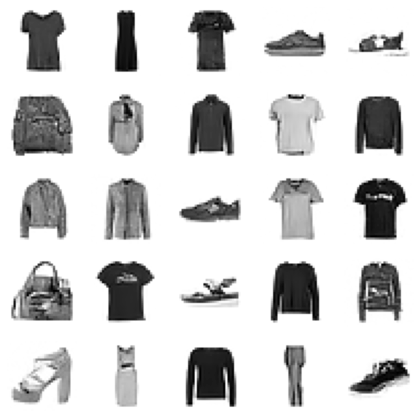

In [94]:
# heun 20 0.5
sample_evaluate(sample_heun, model, steps=20, s_churn=0.5)

tensor(-1.15043, device='cuda:0') tensor(1.45255, device='cuda:0')
5.837646484375 0.0031769333872944117 torch.Size([2048, 1, 32, 32])


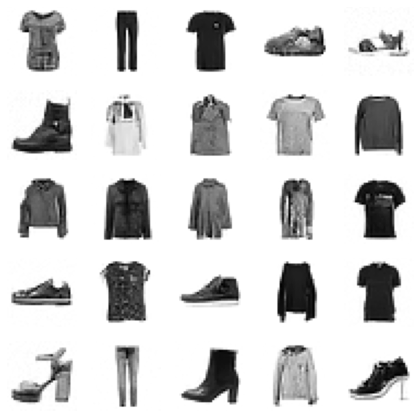

In [96]:
# lms 20
set_seed(42)
preds = sample_lms(model, steps=20, order=3)
s = preds[-1]
print(s.min(), s.max())
show_images(s[:25].clamp(-1, 1), imsize=1.5)
print(ie.fid(s),ie.kid(s),s.shape)

In [101]:
# reals
set_seed(42)
xb,yb = next(iter(dt))
ie.fid(xb)

0.55517578125

In [89]:
from scipy import integrate

In [90]:
def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j == k: continue
            prod *= (tau-t[i-k]) / (t[i-j]-t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

In [91]:
@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    ds = []
    for i in progress_bar(range(len(sigs)-1)):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x-denoised)/sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds